In [178]:
import pandas as pd
import regex as re
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt

This notebook provides code for the cluster analysis.  The clusters were then employed as features for supervised learning.
A separate notebook was used to display the clusters on a map of hurricane affected counties.

In [179]:
#selected housing characteristics dataset
dp_04=pd.read_csv("ACSDP5Y2023.DP04-Data.csv", low_memory=False, skiprows=1)

In [180]:
#selected economic characteristics dataset
cp_03=pd.read_csv("ACSCP5Y2023.CP03-Data.csv", low_memory=False, skiprows=1)

In [181]:
#Columns were selected based on physical characteristics, such as number of rooms and the year of construction.
dp_04_column_list=['Geography',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!5 to 9 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier','fipsStateCode','fipsCountyCode']

In [182]:
#Columns were selected to depict the share of the population at each income level, as well as median income
cp_03_column_list=['Geography',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Less than $10,000',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$10,000 to $14,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$15,000 to $24,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$25,000 to $34,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$35,000 to $49,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$50,000 to $74,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$75,000 to $99,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$100,000 to $149,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$150,000 to $199,999',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$200,000 or more',
 '2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)',
 'fipsStateCode','fipsCountyCode']


In [183]:
#import the FEMA disaster declarations dataset.  This provides the top ten most affected states and their counties
fema_df = pd.read_csv("fema_data 6.1.2025.csv",index_col=False)

In [184]:
#create a list of the top ten states for hurricanes that can be used to filter the Census data
top_ten=fema_df['fipsStateCode'].unique().tolist()
top_ten

[48, 12, 45, 72, 28, 37, 22, 1, 13, 51]

In [185]:
#FEMA data has the state and county FIPS code as features.  The Census data has a GEOID that contains both numbers combined
#Creating new features that isolates the state and county FIPS codes allows for later merging of dataframes
def get_fips_code(df):
    
    df['fipsStateCode']=None
    df['fipsCountyCode']=None
    
    for i in range(len(df)):
        df['fipsStateCode']=df['Geography'].str.slice(start=-5,stop=-3).astype('int64')
        df['fipsCountyCode']=df['Geography'].str.slice(start=-3).astype('int64')
        
    return df

In [186]:
# Drop the first ten rows as they contain state information
dp_04 = dp_04.tail(-10)

In [187]:
cp_03.head()

,Geography,Geographic Area Name,2019-2023 Estimates!!EMPLOYMENT STATUS!!Population 16 years and over,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over,2019-2023 Estimates!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,2019-2023 Estimates!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,2019-2023 Estimates!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,Statistical Significance!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,...,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Under 18 years,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Under 18 years!!Related children of the householder under 18 years,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Under 18 years!!Related children of the householder under 18 years!!Related children of the householder under 5 years,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Under 18 years!!Related children of the householder under 18 years!!Related children of the householder 5 to 17 years,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!18 to 64 years,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!65 years and over,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!People in families,2014-2018 Estimates!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Unrelated individuals 15 years and over,Unnamed: 413
0,0500000US01001,"Autauga County, Alabama",47508,*,59.0,NaN,57.0,NaN,55.5,NaN,...,22.7,22.7,17.7,24.3,13.0,14.0,8.7,14.0,24.3,NaN
1,0500000US01003,"Baldwin County, Alabama",195048,*,58.3,NaN,58.0,NaN,56.2,NaN,...,13.4,13.2,15.4,12.4,9.8,10.4,8.0,7.9,23.2,NaN
2,0500000US01005,"Barbour County, Alabama",20253,*,44.9,NaN,44.8,NaN,42.2,NaN,...,47.6,47.6,59.9,43.4,23.1,25.4,16.2,27.8,34.4,NaN
3,0500000US01007,"Bibb County, Alabama",18176,*,51.6,*,51.6,*,46.4,NaN,...,20.2,19.6,14.1,21.7,12.2,13.3,8.1,11.3,31.9,NaN
4,0500000US01009,"Blount County, Alabama",47389,*,57.4,*,57.4,*,54.0,*,...,21.6,21.5,23.9,20.6,12.2,12.9,10.1,12.2,30.4,NaN


In [188]:
# Drop rows that do not fit our pattern for State/County FIPS codes
print(cp_03.shape)
correct_pattern = r'US\d{5,}$'
cp_03 = cp_03[cp_03['Geography'].str.contains(correct_pattern)]
cp_03.shape

(2893, 414)


(2893, 414)

In [189]:
#Creating the new FIPS code features for the Census data
new_dp_04 = get_fips_code(dp_04)
new_cp_03 = get_fips_code(cp_03)

In [190]:
#filtering Census data for the top ten hurricane affected states
top_ten_dp_04=new_dp_04[new_dp_04['fipsStateCode'].isin(top_ten)]
top_ten_cp_03=new_cp_03[new_cp_03['fipsStateCode'].isin(top_ten)]

In [191]:
#creating dataframes based on the column lists created earlier
housing = top_ten_dp_04[dp_04_column_list].reset_index()
econ = top_ten_cp_03[cp_03_column_list].reset_index()

In [192]:
econ

,index,Geography,"2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Less than $10,000","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$10,000 to $14,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$15,000 to $24,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$25,000 to $34,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$35,000 to $49,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$50,000 to $74,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$75,000 to $99,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$100,000 to $149,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$150,000 to $199,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$200,000 or more",2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars),fipsStateCode,fipsCountyCode
0,0,0500000US01001,3.7,3.0,7.9,9.1,11.4,18.2,15.1,15.3,7.9,8.4,69841,1,1
1,1,0500000US01003,4.2,3.8,6.4,7.8,11.4,16.5,14.1,18.3,8.0,9.7,75019,1,3
2,2,0500000US01005,10.6,6.5,14.2,11.8,12.9,15.8,8.4,12.6,3.3,3.8,44290,1,5
3,3,0500000US01007,6.4,8.0,11.0,10.5,13.2,16.0,13.5,13.2,4.9,3.2,51215,1,7
4,4,0500000US01009,6.1,5.4,8.1,9.1,13.9,16.4,12.6,16.3,6.7,5.5,61096,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2888,0500000US72145,21.6,11.5,19.0,10.8,13.9,11.2,6.6,3.4,0.7,1.3,23877,72,145
975,2889,0500000US72147,21.2,8.3,36.7,19.0,8.7,4.6,1.5,0.0,0.0,0.0,17531,72,147
976,2890,0500000US72149,19.8,11.6,18.8,12.8,14.1,11.0,4.3,6.2,0.7,0.8,24882,72,149
977,2891,0500000US72151,22.7,13.1,22.1,13.7,14.4,9.5,2.5,1.5,0.3,0.2,21279,72,151


In [193]:
#an additional dataframe for housing building type.  Not used in final models.
housing_type=housing[[ 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!5 to 9 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home',
 'Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.','fipsStateCode','fipsCountyCode','Geography']]

In [194]:
#This function creates a fipsCode feature to merge individual counties with the Census data.
fema_df['fipsCode']=None
for i in range(len(fema_df)):
    statecode=str(fema_df['fipsStateCode'].iloc[i])
    countycode=str(fema_df['fipsCountyCode'].iloc[i])
    if len(statecode)<2:
        statecode='0'+statecode
    if len(countycode)<3:
        if len(countycode)<2:
            countycode='00'+countycode
        else:
            countycode='0'+countycode
    fema_df['fipsCode'].iloc[i] = statecode+countycode

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_32309/4232843327.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fema_df['fipsCode'].iloc[i] = statecode+countycode
/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_32

In [195]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import SparsePCA
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import silhouette_visualizer

In [196]:
#function to implement PCA on the Census data
def reduce(df, components):
    pca_df=df.drop(columns=['Geography','fipsStateCode','fipsCountyCode'])
    X = pca_df.to_numpy()
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(X)
    #return KernelPCA(n_components=components, random_state=42, kernel='rbf').fit_transform(X)
    pca=PCA(n_components=components).fit(scaled_data)
    print(pca.explained_variance_ratio_)
    return pca.transform(scaled_data)


In [197]:
#a function to implement kernel PCA - not used in final model
def kernel_reduce(df, components):
    pca_df=df.drop(columns=['Geography','fipsStateCode','fipsCountyCode'])
    X = pca_df.to_numpy()
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(X)
    return KernelPCA(n_components=components, random_state=42, kernel='rbf').fit_transform(scaled_data)

In [198]:
#function to implement sparse PCA for easier interpretability
def sparse_reduce(df, components):
    pca_df=df.drop(columns=['Geography','fipsStateCode','fipsCountyCode'])
    X = pca_df.to_numpy()
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(X)
    return SparsePCA(n_components=components,random_state=42).fit_transform(scaled_data)
    

In [199]:
#function for kmeans to explore different numbers of clusters
def kmeans(data, num_cluster):
    return KMeans(n_clusters=num_cluster, random_state=42, n_init=10).fit_predict(data)
    

In [200]:
#function for agglomerative clustering to explore different numbers of clusters
def agg_cluster(data, num_cluster):
    return AgglomerativeClustering(n_clusters=num_cluster).fit_predict(data)
    

In [201]:
#function to generate scree plots to determine number of principal components
def scree_plot(df, title):
    pca_df=df.drop(columns=['Geography','fipsStateCode','fipsCountyCode'])
    X = pca_df.to_numpy()
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(X)
    pca=PCA()
    comps=pca.fit(scaled_data)

    plt.plot(comps.explained_variance_ratio_)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('Scree plot - {}'.format(title))
    plt.show()

In [202]:
#function that generates a heatmap to examine PCA loadings
def pca_heatmap(df, components, category):
    pca_df=df.drop(columns=['Geography','fipsStateCode','fipsCountyCode','index'])
    X = pca_df.to_numpy()
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(X)
    #pca=PCA(n_components=components).fit(scaled_data)
    pca=SparsePCA(n_components=components,random_state=42).fit(scaled_data)
    
    pc=pca.components_
    col=pca_df.columns.to_list()
    cols=[]
    for c in col:
        name=re.findall(r"(?:[A-Z].*!!)([A-Z].*)",c)
        cols.append(name)
    rows=list(range(components))

    #modified from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, ax = plt.subplots(figsize=(8,16))
    im = ax.imshow(pc)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(cols)), labels=cols,
              rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(rows)), labels=rows)

    # Loop over data dimensions and create text annotations.
    fig.colorbar(plt.cm.ScalarMappable(),
             ax=ax, label="PC Loading", shrink=.1)
    
    ax.set_title("Loadings of principal components for {}".format(category))
    fig.tight_layout()
    plt.show()

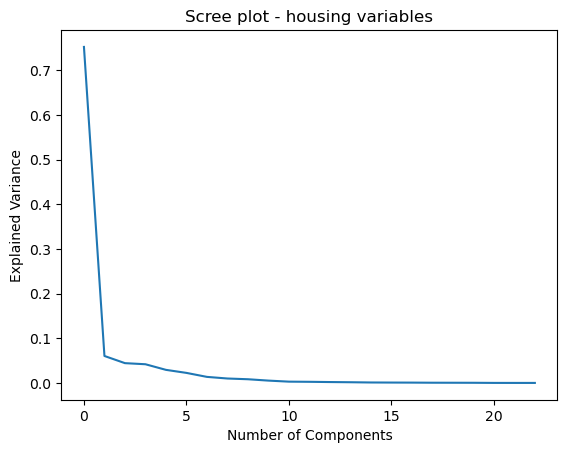

In [203]:
#generate the scree plots, to keep the notebook brief screenshots were captured and migrated to the report
scree_plot(housing, 'housing variables')

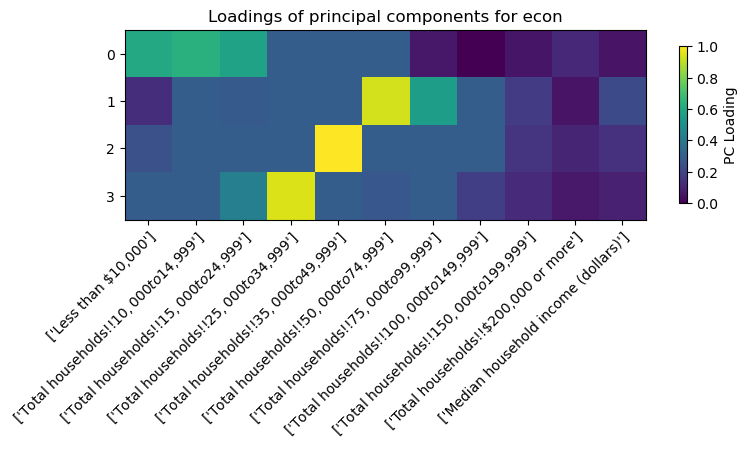

In [204]:
pca_heatmap(econ, 4, 'econ')

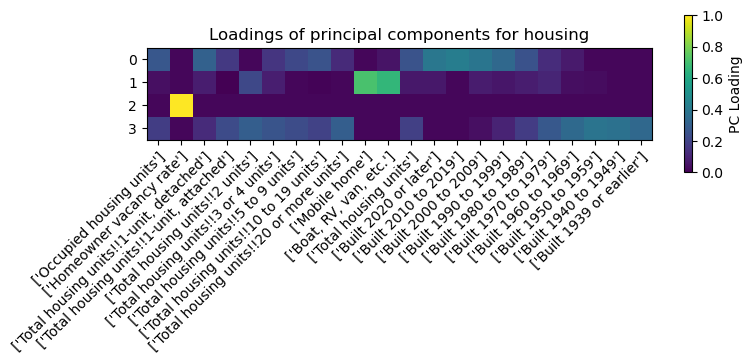

In [205]:
pca_heatmap(housing, 4, 'housing')

In [206]:
colors=['blue','orange','red','green','purple','brown','pink','gray','white','olive','cyan']
plt.style.use('default')

Agglomerative Clustering with PCA

In [207]:
house_pca=sparse_reduce(housing,4)
econ_pca=sparse_reduce(econ,4)
house_type_pca=sparse_reduce(housing_type,4)

Davies-Bouldin Index: 0.3978095083375619 Num clusters: 2
Calinski-Harabasz Index: 874.5240689825553 Num clusters: 3
Silhouette Score: 0.9075671604971675 Num clusters: 2


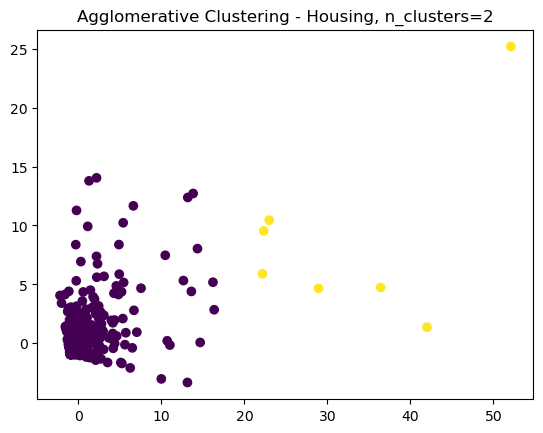

In [208]:
#initialize variables for metrics.  Variable was initialized with the 'worst' score.  Loop created to iterate from 
#2 to 10 clusters and best score retained.  Scatter plot of best cluster is generated.
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    house_clusters=agg_cluster(house_pca,k)

    dav_bou_score = davies_bouldin_score(house_pca,house_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(house_pca,house_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(house_pca,house_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

house_clusters=agg_cluster(house_pca,best_silh_k)
plt.scatter(house_pca[:,0], house_pca[:,1], c=house_clusters)
plt.title('Agglomerative Clustering - Housing, n_clusters={}'.format(best_silh_k))
plt.show()

Davies-Bouldin Index: 0.6099654885354234 Num clusters: 2
Calinski-Harabasz Index: 584.5649870134316 Num clusters: 4
Silhouette Score: 0.48865361265974555 Num clusters: 2


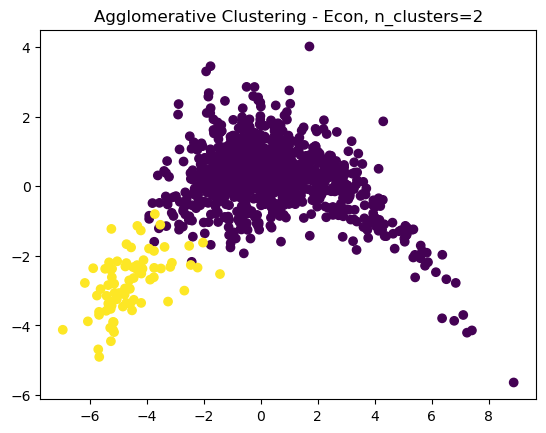

In [209]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    econ_clusters=agg_cluster(econ_pca,k)

    dav_bou_score = davies_bouldin_score(econ_pca,econ_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(econ_pca,econ_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(econ_pca,econ_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

econ_clusters=agg_cluster(econ_pca,best_silh_k)
plt.scatter(econ_pca[:,0], econ_pca[:,1], c=econ_clusters)
plt.title('Agglomerative Clustering - Econ, n_clusters={}'.format(best_silh_k))
plt.show()

Spectral Clustering

In [210]:
#def spectral_clusters(data,num_clusters):
#    return SpectralClustering(random_state=42, n_clusters=num_clusters).fit_predict(data)

In [211]:
#house_spec=spectral_clusters(house_pca,5)
#econ_spec=spectral_clusters(econ_pca,5)

In [212]:
#plt.scatter(house_pca[:,0], house_pca[:,1], c=house_spec)
#plt.title('Spectral Clustering - Housing, n_clusters=5')
#plt.show()

In [213]:
#dav_bou_score = davies_bouldin_score(house_pca,house_spec)
#print('Davies-Bouldin Score:', dav_bou_score)
#cal_har_score=calinski_harabasz_score(house_pca,house_spec)
#print('Calinski-Harabasz Score:',cal_har_score)
#silh_score=silhouette_score(house_pca,house_spec)
#print('Silhouette Score:', silh_score)

In [214]:
#plt.scatter(econ_pca[:,0], econ_pca[:,1], c=econ_spec)
#plt.title('Spectral Clustering - Economic Characteristics, n_clusters=5')
#plt.show()

In [215]:
#dav_bou_score = davies_bouldin_score(econ_pca,econ_spec)
#print('Davies-Bouldin Score:', dav_bou_score)
#cal_har_score=calinski_harabasz_score(econ_pca,econ_spec)
#print('Calinski-Harabasz Score:',cal_har_score)
#silh_score=silhouette_score(econ_pca,econ_spec)
#print('Silhouette Score:', silh_score)

KMeans Clusters with PCA

Davies-Bouldin Index: 0.5433841398608341 Num clusters: 2
Calinski-Harabasz Index: 1020.5150443384199 Num clusters: 2
Silhouette Score: 0.8742804276066649 Num clusters: 2


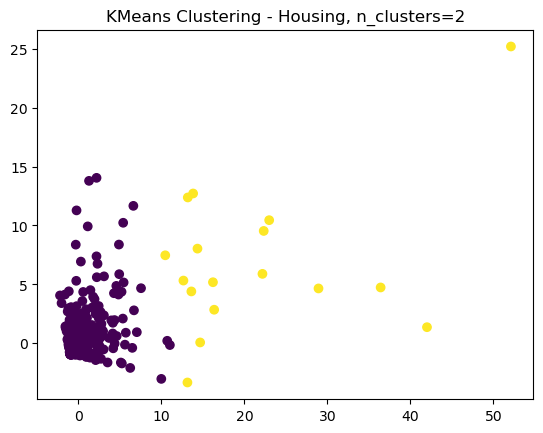

In [216]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    house_clusters=kmeans(house_pca,k)

    dav_bou_score = davies_bouldin_score(house_pca,house_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(house_pca,house_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(house_pca,house_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

house_kmean=kmeans(house_pca,best_silh_k)
plt.scatter(house_pca[:,0], house_pca[:,1], c=house_kmean)
plt.title('KMeans Clustering - Housing, n_clusters={}'.format(best_silh_k))
plt.show()

Davies-Bouldin Index: 0.8738630999368997 Num clusters: 3
Calinski-Harabasz Index: 662.1722133181156 Num clusters: 3
Silhouette Score: 0.38884179699875576 Num clusters: 3


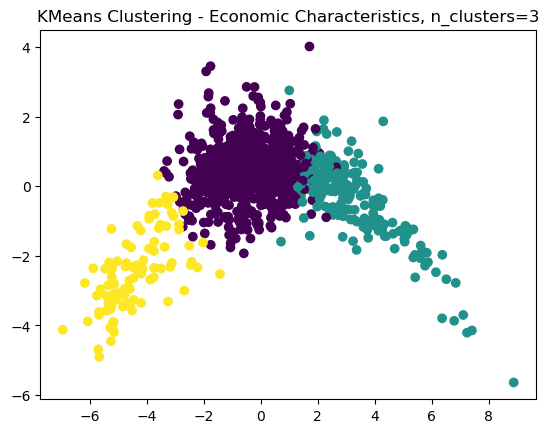

In [217]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    econ_clusters=kmeans(econ_pca,k)

    dav_bou_score = davies_bouldin_score(econ_pca,econ_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(econ_pca,econ_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(econ_pca,econ_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

econ_kmean=kmeans(econ_pca,best_silh_k)
plt.scatter(econ_pca[:,0], econ_pca[:,1], c=econ_kmean)
plt.title('KMeans Clustering - Economic Characteristics, n_clusters={}'.format(best_silh_k))
plt.show()

Agglomerative Clustering with Sparse PCA

In [218]:
house_sparse_pca=sparse_reduce(housing,4)
econ_sparse_pca=sparse_reduce(econ,4)

In [219]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    house_clusters=agg_cluster(house_sparse_pca,k)

    dav_bou_score = davies_bouldin_score(house_sparse_pca,house_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(house_sparse_pca,house_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(house_sparse_pca,house_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

Davies-Bouldin Index: 0.3978095083375619 Num clusters: 2
Calinski-Harabasz Index: 874.5240689825553 Num clusters: 3
Silhouette Score: 0.9075671604971675 Num clusters: 2


In [220]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    econ_clusters=agg_cluster(econ_sparse_pca,k)

    dav_bou_score = davies_bouldin_score(econ_sparse_pca,econ_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(econ_sparse_pca,econ_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(econ_sparse_pca,econ_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

Davies-Bouldin Index: 0.6099654885354234 Num clusters: 2
Calinski-Harabasz Index: 584.5649870134316 Num clusters: 4
Silhouette Score: 0.48865361265974555 Num clusters: 2


KMeans with Sparse PCA

In [221]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    house_clusters=kmeans(house_sparse_pca,k)

    dav_bou_score = davies_bouldin_score(house_sparse_pca,house_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(house_sparse_pca,house_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(house_sparse_pca,house_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

Davies-Bouldin Index: 0.5433841398608341 Num clusters: 2
Calinski-Harabasz Index: 1020.5150443384199 Num clusters: 2
Silhouette Score: 0.8742804276066649 Num clusters: 2


In [222]:
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    econ_clusters=kmeans(econ_sparse_pca,k)

    dav_bou_score = davies_bouldin_score(econ_sparse_pca,econ_clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(econ_sparse_pca,econ_clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(econ_sparse_pca,econ_clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

Davies-Bouldin Index: 0.8738630999368997 Num clusters: 3
Calinski-Harabasz Index: 662.1722133181156 Num clusters: 3
Silhouette Score: 0.38884179699875576 Num clusters: 3


Join datasets together

Create clusters dataset with 2 clusters

In [223]:
#since 2 clusters had best performance, create dataset with 2 clusters
sparse_house_2_clusters=agg_cluster(house_sparse_pca,2)
sparse_econ_2_clusters=agg_cluster(econ_sparse_pca,2)

In [224]:
#create series of clusters and join together
house_agg=pd.Series(sparse_house_2_clusters, name='housing_cluster')
econ_k=pd.Series(sparse_econ_2_clusters, name='econ_cluster')
#join the dataframes from PCA with the clusters
house_df=housing.join(house_agg)
econ_df=econ.join(econ_k)

In [225]:
econ_df

,index,Geography,"2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Less than $10,000","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$10,000 to $14,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$15,000 to $24,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$25,000 to $34,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$35,000 to $49,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$50,000 to $74,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$75,000 to $99,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$100,000 to $149,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$150,000 to $199,999","2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!$200,000 or more",2019-2023 Estimates!!INCOME AND BENEFITS (IN 2023 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars),fipsStateCode,fipsCountyCode,econ_cluster
0,0,0500000US01001,3.7,3.0,7.9,9.1,11.4,18.2,15.1,15.3,7.9,8.4,69841,1,1,0
1,1,0500000US01003,4.2,3.8,6.4,7.8,11.4,16.5,14.1,18.3,8.0,9.7,75019,1,3,0
2,2,0500000US01005,10.6,6.5,14.2,11.8,12.9,15.8,8.4,12.6,3.3,3.8,44290,1,5,0
3,3,0500000US01007,6.4,8.0,11.0,10.5,13.2,16.0,13.5,13.2,4.9,3.2,51215,1,7,0
4,4,0500000US01009,6.1,5.4,8.1,9.1,13.9,16.4,12.6,16.3,6.7,5.5,61096,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2888,0500000US72145,21.6,11.5,19.0,10.8,13.9,11.2,6.6,3.4,0.7,1.3,23877,72,145,1
975,2889,0500000US72147,21.2,8.3,36.7,19.0,8.7,4.6,1.5,0.0,0.0,0.0,17531,72,147,1
976,2890,0500000US72149,19.8,11.6,18.8,12.8,14.1,11.0,4.3,6.2,0.7,0.8,24882,72,149,1
977,2891,0500000US72151,22.7,13.1,22.1,13.7,14.4,9.5,2.5,1.5,0.3,0.2,21279,72,151,1


In [226]:
#create dataframes for merging.  Census dataframe was not used as econ and housing are of different lengths 
econ_merge=econ_df[['fipsStateCode','fipsCountyCode','econ_cluster']].copy()
house_merge=house_df[['fipsStateCode','fipsCountyCode','housing_cluster']].copy()
#census_merge=house_merge.merge(econ_merge,on=['fipsStateCode','fipsCountyCode'],how='inner')

In [227]:
econ_merge

,fipsStateCode,fipsCountyCode,econ_cluster
0,1,1,0
1,1,3,0
2,1,5,0
3,1,7,0
4,1,9,0
...,...,...,...
974,72,145,1
975,72,147,1
976,72,149,1
977,72,151,1


In [228]:
#inner join preserves all observations for housing
fema_merge_1=fema_df.merge(house_merge,on=['fipsStateCode','fipsCountyCode'],how='inner')

In [229]:
#econ dataframe does not include all counties, so a left join was used to preserve all counties with complete housing observations
final=fema_merge_1.merge(econ_merge,on=['fipsStateCode','fipsCountyCode'],how='left')

In [230]:
final

,Unnamed: 0,disasterNumber,declarationTitle,state,Date,fipsStateCode,fipsCountyCode,placeCode,year,county,...,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,validReg_rent,ModerateDamage_rent,MajorDamage_rent,SubstDamage_rent,fipsCode,housing_cluster,econ_cluster
0,0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,99015,2024,Austin (County),...,10.0,1.0,4.0,406.0,10.0,1.0,0.0,48015,0,0.0
1,1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,99037,2024,Bowie (County),...,7.0,0.0,0.0,1038.0,23.0,1.0,0.0,48037,0,0.0
2,2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,99039,2024,Brazoria (County),...,584.0,73.0,29.0,21580.0,630.0,11.0,0.0,48039,0,0.0
3,3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,99071,2024,Chambers (County),...,22.0,4.0,0.0,1133.0,33.0,0.0,0.0,48071,0,0.0
4,4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,99157,2024,Fort Bend (County),...,299.0,14.0,6.0,35331.0,460.0,5.0,0.0,48157,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,2016,4734,HURRICANE IDALIA,FL,2023-08-27 00:00:00+00:00,12,101,99101,2023,Pasco (County),...,536.0,41.0,3.0,2494.0,387.0,1.0,0.0,12101,0,0.0
1741,2017,4734,HURRICANE IDALIA,FL,2023-08-27 00:00:00+00:00,12,103,99103,2023,Pinellas (County),...,655.0,19.0,16.0,10678.0,494.0,0.0,0.0,12103,0,0.0
1742,2018,4734,HURRICANE IDALIA,FL,2023-08-27 00:00:00+00:00,12,115,99115,2023,Sarasota (County),...,22.0,2.0,1.0,632.0,12.0,0.0,0.0,12115,0,0.0
1743,2019,4734,HURRICANE IDALIA,FL,2023-08-27 00:00:00+00:00,12,121,99121,2023,Suwannee (County),...,48.0,12.0,12.0,2715.0,270.0,3.0,0.0,12121,0,0.0


In [ ]:
final=final[['fipsCode','housing_cluster','econ_cluster']].copy()

In [ ]:
final.to_csv('clusters_n_2.csv')